In [1]:
%cd /home/pepa/PycharmProjects/claim-rank
!export PYTHONPATH=.
%load_ext autoreload
%autoreload 2

/home/pepa/PycharmProjects/claim-rank


In [3]:
import numpy as np
import random
import tensorflow as tf
np.random.seed(42) # ! before importing keras!
from src.data.debates import read_debates, Debate
from src.features.feature_sets import get_cb_pipeline, get_serialized_pipeline
from keras.layers import Input, Embedding, Conv1D, Dense, LSTM, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.initializers import *
from keras.optimizers import RMSprop
from keras.layers import Input, Dense, Dropout
from src.stats.rank_metrics import average_precision, precision_at_n
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import time
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import regularizers
from keras.layers import BatchNormalization
from src.stats.rank_metrics import average_precision, precision_at_n
from keras.utils.np_utils import to_categorical

In [4]:
# PREPARE DATA
train_sentences = read_debates(Debate.FIRST) + read_debates(Debate.VP) + read_debates(Debate.SECOND)
val_sentences = read_debates(Debate.THIRD)

pipeline = get_serialized_pipeline(train=train_sentences)
X_train = pipeline.fit_transform(train_sentences)
X_val = pipeline.transform(val_sentences)

y_train_pf = np.array([s.labels[5] for s in train_sentences])
y_train_all = np.array([1 if s.label>0 else 0 for s in train_sentences])
y_train_wp = np.array([s.labels[4] for s in train_sentences])

y_val_pf = np.array([s.labels[5] for s in val_sentences])
y_val_all = np.array([1 if s.label>0 else 0 for s in val_sentences])
y_val_wp = np.array([s.labels[4] for s in val_sentences])

print(X_train.shape)
print(train_sentences[103].labels)
print(train_sentences[103].label)
print(X_train[0].shape)
print(np.array(y_train_all).shape)

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(4064, 1118)
['0', '0', '1', '0', '0', '0', '0', '0', '0']
1
(1118,)
(4064,)


In [5]:
# CALLBACKS
timestamp = int(time.time())
run_name='multitask'
weights_filename = run_name+'model_multitask'+str(timestamp)
# tensor_board_cb = TensorBoard(log_dir='./logs/'+run_name+str(timestamp))
model_checkpoint = ModelCheckpoint('./saved_models/'+weights_filename, monitor='val_pred_any_acc', 
                                   save_best_only=True, verbose=2, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_pred_any_loss', patience=20, verbose=2)
callbacks = [model_checkpoint, early_stopping]
# MODEL
# shared layer
input_layer = Input(shape=(X_train.shape[1],), name='input')
dense_shared = Dense(1000, name='dense_shared', activation='linear',
              kernel_initializer=lecun_normal(seed=42), kernel_regularizer=regularizers.l2(0.001))(input_layer)
lrelu_shared = LeakyReLU(name='shared_lrelu')(dense_shared)
drop_shared = Dropout(0.3)(lrelu_shared)

# any layer
dense_any = Dense(500, name='dense_any', activation='linear',
               kernel_initializer=lecun_normal(seed=42), kernel_regularizer=regularizers.l2(0.001))(drop_shared)
lrelu_any = LeakyReLU(name='any_lrelu')(dense_any)
drop_any = Dropout(0.3)(lrelu_any)
pred_any = Dense(1, activation='sigmoid', name='pred_any', 
                 kernel_initializer=lecun_normal(seed=42), kernel_regularizer=regularizers.l2(0.001))(drop_any)

# one(pf) layer
dense_one = Dense(500, name='dense_one', activation='linear',
               kernel_initializer=lecun_normal(seed=42), kernel_regularizer=regularizers.l2(0.001))(drop_shared)
lrelu_one = LeakyReLU(name='one_lrelu')(dense_one)
drop_one = Dropout(0.3)(lrelu_one)
pred_pf = Dense(1, activation='sigmoid', name='pred_pf', 
                kernel_initializer=lecun_normal(seed=42), kernel_regularizer=regularizers.l2(0.001))(drop_one)

model = Model(inputs=[input_layer], outputs=[pred_any, pred_pf])
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y=[y_train_all, y_train_pf], validation_data=(X_val, [y_val_all, y_val_pf]), epochs=100, 
          batch_size=64, callbacks = callbacks)

Train on 4064 samples, validate on 1351 samples
Epoch 1/100
4064/4064 [==============================] - 5s 1ms/step - loss: 1.6770 - pred_any_loss: 0.5547 - pred_pf_loss: 0.2472 - pred_any_acc: 0.8216 - pred_pf_acc: 0.9299 - val_loss: 1.2592 - val_pred_any_loss: 0.5012 - val_pred_pf_loss: 0.2841 - val_pred_any_acc: 0.8164 - val_pred_pf_acc: 0.9563
Epoch 2/100
4064/4064 [==============================] - 4s 1ms/step - loss: 0.9237 - pred_any_loss: 0.4362 - pred_pf_loss: 0.1956 - pred_any_acc: 0.8393 - pred_pf_acc: 0.9513 - val_loss: 0.8071 - val_pred_any_loss: 0.4548 - val_pred_pf_loss: 0.1786 - val_pred_any_acc: 0.8164 - val_pred_pf_acc: 0.9563
Epoch 3/100
4064/4064 [==============================] - 4s 1ms/step - loss: 0.7149 - pred_any_loss: 0.4046 - pred_pf_loss: 0.1851 - pred_any_acc: 0.8423 - pred_pf_acc: 0.9510 - val_loss: 0.7211 - val_pred_any_loss: 0.4628 - val_pred_pf_loss: 0.1665 - val_pred_any_acc: 0.8164 - val_pred_pf_acc: 0.9563
Epoch 4/100
4064/4064 [====================

In [6]:
model.load_weights('./saved_models/'+weights_filename)

In [7]:
predicted_prob_val = model.predict(X_val)
predicted_val = to_categorical(predicted_prob_val[0], num_classes=2)
for prob, pred, sentence in zip(predicted_prob_val[0], predicted_val, val_sentences):
    sentence.pred = prob[0]
    sentence.pred_label = pred[0]
print(average_precision(val_sentences,1))
print(precision_at_n(val_sentences, n=50, agreement=1))

0.4800917895071177
0.64


In [8]:
predicted_prob_train = model.predict(X_train)
predicted_train = to_categorical(predicted_prob_train[0], num_classes=2)
for prob, pred, sentence in zip(predicted_prob_train[0], predicted_train, train_sentences):
    sentence.pred = prob[0]
    sentence.pred_label = pred[0] 
print(average_precision(train_sentences,1))
print(precision_at_n(train_sentences, n=50, agreement=1))

0.8108767704320184
1.0


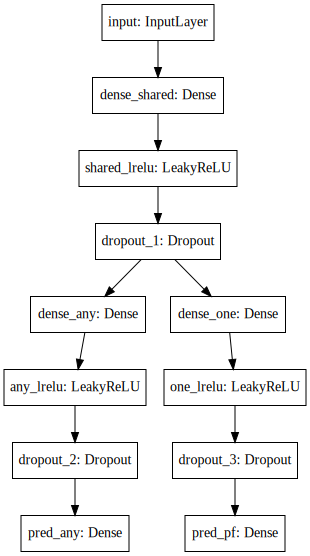

In [9]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))